# KHIEU William

In [1]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

from sklearn.svm import LinearSVC

# Partie 1 : Architecture VGG16

In [2]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
!rm -rf imagenet_classes.pkl
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!rm cat.jpg
!rm dog.jpg
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

--2024-12-24 13:11:32--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl [following]
--2024-12-24 13:11:33--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35454 (35K) [text/plain]
Saving to: ‘imagenet_classes.pkl’

imagenet_classes.pk 100%[===================>]  34.62K  --.-KB/s    in 0.001s  

2024-12-24 13:11:33 (44.0 MB/s) - ‘imagenet_classes.pkl’ saved [35454

In [3]:
import torch
import torch.nn as nn

# Input tensor (batch_size=1, channels=1, height=2, width=2)
input_tensor = torch.tensor([[[[1, 2], [3, 4]]]], dtype=torch.float)

# Deconvolution layer (upsampling to 4x4)
deconv = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, stride=2)

# Initialize weights (for illustration purposes)
deconv.weight.data = torch.tensor([[[[1, 1], [1, 1]]]], dtype=torch.float)

# Forward pass
output = deconv(input_tensor)
print("Deconvolved Output:\n", output)


Deconvolved Output:
 tensor([[[[0.7269, 0.7269, 1.7269, 1.7269],
          [0.7269, 0.7269, 1.7269, 1.7269],
          [2.7269, 2.7269, 3.7269, 3.7269],
          [2.7269, 2.7269, 3.7269, 3.7269]]]], grad_fn=<ConvolutionBackward0>)


/home/hyraeth/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hyraeth/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted class: Egyptian cat


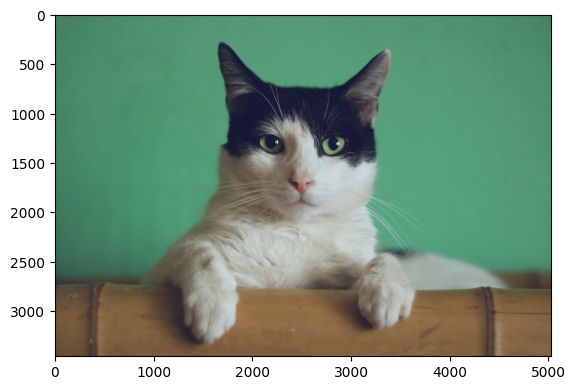

In [4]:
nameim = "cat"+".jpg"
#cat = Image.open('cat.jpg')
img = Image.open(nameim)
plt.imshow(img)

# Loading ImageNet classes
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb'))

# Normalization
img = img.resize((224, 224), Image.BILINEAR)
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))
# ImageNet mean/std
mu = torch.Tensor([0.485, 0.456, 0.406])
sigma = torch.Tensor([0.229, 0.224, 0.225])
# Expand mu & sigma to match image size
mu = mu[:, None, None]
sigma = sigma[:, None, None]
# compute the normalized image with mean ImageNet image
img = (torch.tensor(img) - mu) / sigma

# Loding pre-trained VGG
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.eval() # WHY THAT ? # Because the model is already trained, we disables certain layers (e.g., dropout) that behave differently during training

# Forward pass on VGG
img = np.expand_dims(img, 0)
x = torch.Tensor(img)
with torch.no_grad():  # Disable gradient computation for inference
    y = vgg16(x)
y = y.numpy() # transformation en array numpy

# Get prediction (i.e., ImageNet class label)
predicted_class_index = np.argmax(y)
predicted_class = imagenet_classes[predicted_class_index]

print("Predicted class:", predicted_class)

torch.Size([64, 224, 224])


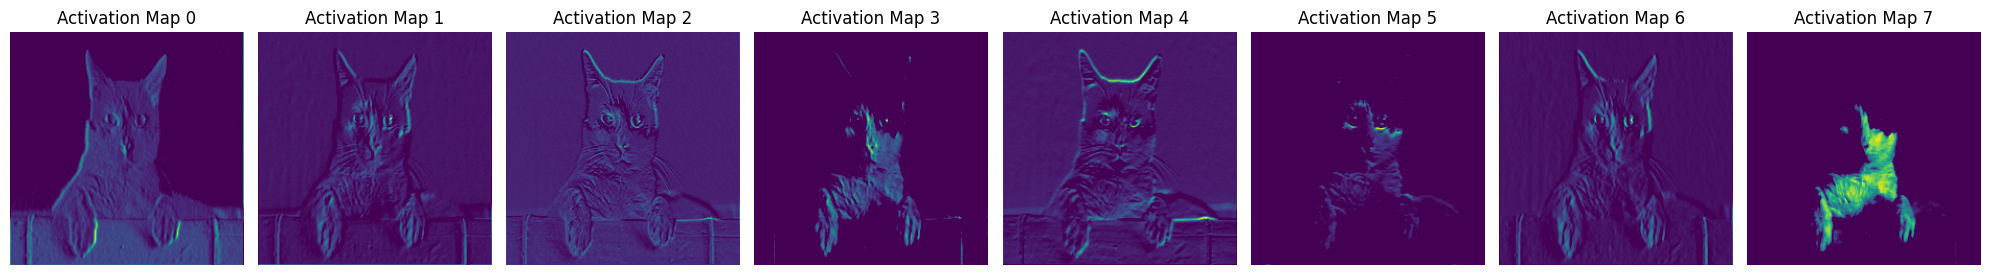

In [5]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 1. Load & Preprocess the image
def preprocess_image(img_path):
    # Load image
    img = Image.open(img_path).convert('RGB')
    # Resize to 224x224
    img = img.resize((224, 224), Image.BILINEAR)
    # Convert to NumPy and scale to [0,1]
    img = np.array(img, dtype=np.float32) / 255.0
    # Transpose to (C,H,W)
    img = img.transpose((2, 0, 1))
    # Convert to Torch tensor
    img_tensor = torch.tensor(img)
    # ImageNet mean and std
    mu = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    sigma = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    # Normalize
    img_tensor = (img_tensor - mu) / sigma
    # Add batch dimension: (1, C, H, W)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor


# 2. Load pre-trained VGG16 and set to eval
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.eval()

# 3. Register a forward hook to capture the activations of the first conv layer
activation = {}
def get_activation(name):
    """ Forward hook to store the layer output in `activation[name]`. """
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# The first convolutional layer in `vgg16.features` is at index 0
vgg16.features[0].register_forward_hook(get_activation('conv1'))

# 4. Forward pass on an example image
img_path = "cat.jpg"  # Replace with your own image path
img_tensor = preprocess_image(img_path)

with torch.no_grad():
    _ = vgg16(img_tensor)  # We don't need the final output, just the hook

# 5. Extract and visualize the activation maps
act = activation['conv1'].squeeze()  # shape: (64, H, W) after removing batch dimension

print(act.shape)
# Let's plot some of them (e.g., first 8 filters)
num_features_to_show = 8
fig, axes = plt.subplots(1, num_features_to_show, figsize=(20, 10))

for i in range(num_features_to_show):
    axes[i].imshow(act[i].cpu().numpy(), cmap='viridis')  
    axes[i].axis('off')
    axes[i].set_title(f"Activation Map {i}")

plt.tight_layout()
plt.savefig('report_a/output1.png', dpi=300, bbox_inches='tight')  # Save the figure
plt.show()


# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [6]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!rm -rf 15ScenesData.zip
!rm -rf /home/hyraeth/M2A/RDFIA/TP2/15SceneData

!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip


!unzip 15ScenesData.zip

--2024-12-24 13:11:42--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip [following]
--2024-12-24 13:11:42--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86520868 (83M) [application/zip]
Saving to: ‘15ScenesData.zip’

15ScenesData.zip    100%[===================>]  82.51M  99.1MB/s    in 0.8s    

2024-12-24 13:11:43 (99.1 MB/s) - ‘15ScenesData.zip’ saved [86520868/86520868

In [7]:
ls 15SceneData/test/bedroom/


image_0003.jpg  image_0042.jpg  image_0082.jpg  image_0124.jpg  image_0170.jpg
image_0004.jpg  image_0043.jpg  image_0084.jpg  image_0128.jpg  image_0175.jpg
image_0006.jpg  image_0047.jpg  image_0086.jpg  image_0130.jpg  image_0176.jpg
image_0007.jpg  image_0049.jpg  image_0087.jpg  image_0131.jpg  image_0180.jpg
image_0008.jpg  image_0050.jpg  image_0088.jpg  image_0134.jpg  image_0182.jpg
image_0011.jpg  image_0052.jpg  image_0090.jpg  image_0135.jpg  image_0189.jpg
image_0013.jpg  image_0053.jpg  image_0092.jpg  image_0138.jpg  image_0190.jpg
image_0014.jpg  image_0054.jpg  image_0093.jpg  image_0140.jpg  image_0191.jpg
image_0016.jpg  image_0056.jpg  image_0095.jpg  image_0141.jpg  image_0192.jpg
image_0017.jpg  image_0059.jpg  image_0096.jpg  image_0142.jpg  image_0195.jpg
image_0018.jpg  image_0060.jpg  image_0097.jpg  image_0144.jpg  image_0196.jpg
image_0019.jpg  image_0062.jpg  image_0098.jpg  image_0148.jpg  image_0200.jpg
image_0020.jpg  image_0063.jpg  image_0103.jpg  imag

In [8]:
class VGG16relu7(nn.Module):
    def __init__(self, pretrained_vgg16):
        super(VGG16relu7, self).__init__()
        # Copy the entire convolutional part
        self.features = nn.Sequential(*list(pretrained_vgg16.features.children()))
        # Keep a piece of the classifier: -2 to stop at relu7
        self.classifier = nn.Sequential(*list(pretrained_vgg16.classifier.children())[:-2])

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [16]:

PRINT_INTERVAL = 50
CUDA = True

def get_dataset(batch_size, path):

    # This function expands 3 times a gray level image
    # to transform it into an image RGB. Use it with transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img
    def resizeImage(img):
      return img.resize((224,224), Image.BILINEAR)

    #####################
    ## YOUR CODE HERE  ##
    #####################
    # Add pre-processing
    train_dataset = datasets.ImageFolder(path + '/train',
        transform=transforms.Compose([
            transforms.Lambda(duplicateChannel),    # Conversion en RGB
            transforms.Lambda(resizeImage),         # Redimensionnement
            transforms.ToTensor(),                  # Conversion en tenseur
            transforms.Normalize(mu, sigma)         # Normalisation
        ]))

    # Dataset de validation avec le même prétraitement
    val_dataset = datasets.ImageFolder(path + '/test',
        transform=transforms.Compose([
            transforms.Lambda(duplicateChannel),
            transforms.Lambda(resizeImage),
            transforms.ToTensor(),
            transforms.Normalize(mu, sigma)
        ]))
    ####################
    ##      END        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [10]:
def extract_features(data, model):
    #####################
    ## YOUR CODE HERE  ##
    #####################
    # init features matrices
    X = []
    y = []
    ####################
    ##      END        #
    ####################

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            input = input.cuda()
        #####################
        ## YOUR CODE HERE  ##
        #####################
        # Feature extraction à faire
        # Extraction des caractéristiques
        with torch.no_grad():  # Pas besoin de calcul des gradients pour l'inférence
            features = model(input)  # Extraire les caractéristiques via VGG16relu7
            features = features.cpu().numpy()  # Transférer sur CPU pour l'utilisation avec SVM

        X.append(features)
        y.append(target.numpy())  # Garder les labels sous forme de numpy array

    # Conversion des listes en matrices NumPy
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)

        ####################
        ##      END        #
        ####################

    return X, y


def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    #####################
    ## YOUR CODE HERE  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle instence de la classe VGG16relu7 ici
    model = VGG16relu7(vgg16)
    ####################
    ##      END        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    #####################
    ## Votre code ici  ##
    #####################
    # Entraînement et évaluation du SVM
    print('Apprentissage des SVM')
    svm = LinearSVC(C=1.0)
    svm.fit(X_train, y_train)  # Entraîner le SVM avec les caractéristiques extraites
    accuracy = svm.score(X_test, y_test)  # Calculer la précision sur les données de test
    ####################
    ##      FIN        #
    ####################
    print('Accuracy = %f' % accuracy)


In [11]:
main("15SceneData", 8)

Instanciation de VGG16
Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy = 0.885762


/home/hyraeth/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Test different depth feature extraction

In [12]:
layer_to_feature_idx = {
    "pool1": 5,   # up to and including index 4 (MaxPool2d #1)
    "pool2": 10,  # up to index 9
    "pool3": 17,  # up to index 16
    "pool4": 24,  # up to index 23
    "pool5": 31,  # up to index 30
}

class TruncatedVGG16(nn.Module):
    def __init__(self, layer_name='pool5'):
        super().__init__()
        
        # Load the full pre-trained VGG16
        vgg_full = models.vgg16(pretrained=True)
        
        # Common: always keep the entire convolutional stack
        self.conv_features = vgg_full.features
        
        # We'll store a flag to remember if we're using a pooling layer or an FC layer
        self.mode = None
        
        # If it's a pooling layer (pool1..pool5):
        if layer_name in layer_to_feature_idx:
            self.mode = 'pool'
            max_idx = layer_to_feature_idx[layer_name]
            # Truncate the features
            self.conv_features = nn.Sequential(*list(vgg_full.features.children())[:max_idx])
            self.layer_name = layer_name
        
        # If it's a fully-connected layer:
        elif layer_name == 'relu6':
            self.mode = 'fc'
            self.layer_name = layer_name
            # Keep the entire conv stack
            # We'll define the classifier up to (and including) relu6
            self.fc = nn.Sequential(
                vgg_full.classifier[0],  # fc6
                vgg_full.classifier[1],  # ReLU
                # We could optionally keep dropout as well, e.g. vgg_full.classifier[2]
                # but if you want EXACT output of 'relu6', it's typically after ReLU
                # We'll also keep dropout if we want the exact same output as the net
                vgg_full.classifier[2],  # Dropout
            )
            
        elif layer_name == 'relu7':
            self.mode = 'fc'
            self.layer_name = layer_name
            # Keep the entire conv stack
            # Then keep fc6 -> ReLU -> Dropout -> fc7 -> ReLU -> Dropout
            self.fc = nn.Sequential(*list(vgg_full.classifier.children())[:-2])
            
        else:
            raise ValueError(f"Invalid layer name: {layer_name}. "
                             f"Use one of {list(layer_to_feature_idx.keys()) + ['relu6','relu7']}")
        
    def forward(self, x):
        # 1. Pass through truncated conv_features
        x = self.conv_features(x)  # shape depends on the last pooling layer included
        
        # If we truncated at a pool layer, we are done
        if self.mode == 'pool':
            # For example, after pool1, shape could be (BS, 64, 112, 112)
            # after pool5, shape = (BS, 512, 7, 7)
            # Flatten for SVM input
            x = x.view(x.size(0), -1)
            return x
        
        # Otherwise, pass through the FC layers (relu6 or relu7)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [13]:
def experiment_pool_layers(path="15SceneData", 
                           batch_size=8,
                           layers_to_try=None):
    """
    Example experiment: Evaluate feature extraction from
    all pooling layers (pool1..pool5) plus optionally relu6 and relu7.
    """
    if layers_to_try is None:
        layers_to_try = [ "pool4", "pool5", 
                         "relu6", "relu7"]
    
    # Prepare CUDA
    if CUDA:
        cudnn.benchmark = True
    
    print("Loading dataset...")
    train_loader, test_loader = get_dataset(batch_size, path)

    results = {}
    
    for layer_name in layers_to_try:
        print(f"\n=== Now testing layer: {layer_name} ===")
        
        # 1. Build truncated model
        model = TruncatedVGG16(layer_name=layer_name)
        if CUDA:
            model = model.cuda()
        
        # 2. Extract features
        start_time = time.time()
        X_train, y_train = extract_features(train_loader, model)
        X_test,  y_test  = extract_features(test_loader,  model)
        feat_time = time.time() - start_time
        print(f"Feature extraction time: {feat_time:.2f} sec")
        print(f"Feature dimension: {X_train.shape[1]}")
        
        # 3. Train SVM
        print("Training SVM...")
        svm = LinearSVC(C=1.0, max_iter=10000)
        start_time = time.time()
        svm.fit(X_train, y_train)
        svm_time = time.time() - start_time
        print(f"SVM training time: {svm_time:.2f} sec")
        
        # 4. Evaluate
        accuracy = svm.score(X_test, y_test)
        print(f"Accuracy @ {layer_name} = {accuracy:.4f}")
        
        # Store results
        results[layer_name] = {
            "accuracy": accuracy,
            "feature_dim": X_train.shape[1],
            "feature_time": feat_time,
            "svm_time": svm_time,
        }
    
    # Summarize
    print("\n=== Summary of Results ===")
    for layer_name, info in results.items():
        print(f"Layer: {layer_name}")
        print(f"  Accuracy:       {info['accuracy']:.4f}")
        print(f"  Feature dim:    {info['feature_dim']}")
        print(f"  Feat. time (s): {info['feature_time']:.2f}")
        print(f"  SVM time (s):   {info['svm_time']:.2f}")
    
    return results



experiment_pool_layers(path="15SceneData", batch_size=8)


/home/hyraeth/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hyraeth/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading dataset...

=== Now testing layer: pool4 ===
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Feature extraction time: 21.45 sec
Feature dimension: 100352
Training SVM...
SVM training time: 21.04 sec
Accuracy @ pool4 = 0.8797

=== Now testing layer: pool5 ===


/home/hyraeth/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hyraeth/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Feature extraction time: 25.23 sec
Feature dimension: 25088
Training SVM...
SVM training time: 2.38 sec
Accuracy @ pool5 = 0.8988

=== Now testing layer: relu6 ===


/home/hyraeth/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hyraeth/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Feature extraction time: 23.03 sec
Feature dimension: 4096
Training SVM...
SVM training time: 0.40 sec
Accuracy @ relu6 = 0.8737

=== Now testing layer: relu7 ===


/home/hyraeth/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hyraeth/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Feature extraction time: 23.06 sec
Feature dimension: 4096
Training SVM...
SVM training time: 0.74 sec
Accuracy @ relu7 = 0.8760

=== Summary of Results ===
Layer: pool4
  Accuracy:       0.8797
  Feature dim:    100352
  Feat. time (s): 21.45
  SVM time (s):   21.04
Layer: pool5
  Accuracy:       0.8988
  Feature dim:    25088
  Feat. time (s): 25.23
  SVM time (s):   2.38
Layer: relu6
  Accuracy:       0.8737
  Feature dim:    4096
  Feat. time (s): 23.03
  SVM time (s):   0.40
Layer: relu7
  Accuracy:       0.8760
  Feature dim:    4096
  Feat. time (s): 23.06
  SVM time (s):   0.74


{'pool4': {'accuracy': 0.8797319932998325,
  'feature_dim': 100352,
  'feature_time': 21.449376106262207,
  'svm_time': 21.04159379005432},
 'pool5': {'accuracy': 0.8988274706867672,
  'feature_dim': 25088,
  'feature_time': 25.23183250427246,
  'svm_time': 2.3793187141418457},
 'relu6': {'accuracy': 0.8737018425460636,
  'feature_dim': 4096,
  'feature_time': 23.025446891784668,
  'svm_time': 0.3959476947784424},
 'relu7': {'accuracy': 0.8760469011725294,
  'feature_dim': 4096,
  'feature_time': 23.057637691497803,
  'svm_time': 0.742525577545166}}

# Trying ResNet50

In [18]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import numpy as np
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
from sklearn.svm import LinearSVC

# ----------------------
# Hyperparameters
# ----------------------
CUDA = True
PRINT_INTERVAL = 50

# Normalization means & stds for ImageNet pretrained models
mu = [0.485, 0.456, 0.406]
sigma = [0.229, 0.224, 0.225]

# ----------------------
# Custom ResNet50 Trunk
# ----------------------
class ResNet50Trunk(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # Load a pretrained ResNet50
        resnet = models.resnet50(pretrained=pretrained)
        # Remove the final FC layer
        # children() in ResNet50: [conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4, avgpool, fc]
        # We remove the 'fc' layer so that we only keep up to global avgpool
        self.trunk = nn.Sequential(*list(resnet.children())[:-1])

    def forward(self, x):
        # Pass through the truncated ResNet
        x = self.trunk(x)         # shape: (batch_size, 2048, 1, 1)
        x = x.view(x.size(0), -1) # Flatten to (batch_size, 2048)
        return x

# ----------------------
# Main routine
# ----------------------
def main(path="15SceneData", batch_size=8):
    # 1. Instantiate truncated ResNet50
    print("Loading truncated ResNet50...")
    resnet_trunk = ResNet50Trunk(pretrained=True)
    resnet_trunk.eval()

    if CUDA:
        cudnn.benchmark = True
        resnet_trunk = resnet_trunk.cuda()

    # 2. Load data
    print("Loading data...")
    train_loader, test_loader = get_dataset(batch_size, path)

    # 3. Extract features
    print("Extracting features...")
    X_train, y_train = extract_features(train_loader, resnet_trunk)
    X_test, y_test = extract_features(test_loader, resnet_trunk)

    # 4. Train an SVM
    print("Training SVM (LinearSVC)...")
    from sklearn.svm import LinearSVC
    svm = LinearSVC(C=1.0, max_iter=5000)  # you can tweak max_iter
    svm.fit(X_train, y_train)

    # 5. Evaluate
    accuracy = svm.score(X_test, y_test)
    print(f"Test accuracy = {accuracy:.4f}")

main(path="15SceneData", batch_size=8)


Loading truncated ResNet50...
Loading data...
Extracting features...
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Training SVM (LinearSVC)...
Test accuracy = 0.9082
